### PROJECT DESCRIPTION
Estimate the value of houses in Ames, Iowa, using 79 explanatory variables. The dataset is fairly small, with only 1460 training samples. The 79 features in the dataset are a mix of categorical and numerical features, and leave a lot of room for feature engineering.

This notebook merely preprocesses the data. 
Note: This is the first most basic preprocessing version used for models tested in chapter 1 and 2. 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import tensorflow.keras as tf
import pandas as pd
import numpy as np

In [ ]:
get_dummies = False

In [ ]:
# determine tresholds for feature selection here:

# numeric data
correlation_treshold = 0.25

# categorical data
percentage_treshold = 0.1

In [ ]:
# import data form keggle competition
clean_data = pd.read_csv('data/AmesHousing.csv')
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

clean_data.head()

There are multiple types of variables. Integers, floats, strings, NaN's. Use df.info() to gain detailed insight.


In [ ]:
# display data information
clean_data.info()

There are 2930 entries, numbered 0 to 2929, with **81 different features**. The **target feature** is 'SalePrice'. 

Out of all the columns there are several that have missing values. For instance, 'Alley', 'Pool QC', 'Fence', and 'Misc Feature'. These need to be fixed. 

### Cleaning the data

#### Dropping features
Drop features that are outliers, or have of which (almost) all data falls in the same category, or have unique values for each datapoint.

In [ ]:
# drop column 'Order' since it is unique for each house
clean_data = clean_data.drop('Order', axis=1)

In [ ]:
# drop column 'Order' since (almost) all data falls in the same category (> 95% in one category)
clean_data = clean_data.drop('Street', axis=1)
clean_data = clean_data.drop('Utilities', axis=1)
clean_data = clean_data.drop('Condition 2', axis=1)
clean_data = clean_data.drop('Roof Matl', axis=1)
clean_data = clean_data.drop('Heating', axis=1)
clean_data = clean_data.drop('Misc Feature', axis=1)

First, the ourliers are checked by plotting the general living area with sale price, as is mentioned in the documentation of the dataset.

In [ ]:
sns.scatterplot(clean_data['Gr Liv Area'], clean_data['SalePrice'])
plt.show()

Garage year built is also plotted, since this shows also an outlier that is not possible

In [ ]:
# plotting the garage year built to show outliers
sns.scatterplot(clean_data['Garage Yr Blt'], clean_data['SalePrice'])
plt.show()

There are 5 ourliers visible that can be removed by removing datasamples with a general living area greater than 4000.

In [ ]:
mask = clean_data['Gr Liv Area'] > 4000
drop_sample = clean_data[mask]
clean_data = clean_data.drop(drop_sample.index, axis = 0)

Additionally, the value for the garage that is build after 2200 is replaces by NaN. 

In [ ]:
mask = clean_data['Garage Yr Blt'] > 2010
outlier_garage = clean_data['Garage Yr Blt'][mask]
clean_data['Garage Yr Blt'][outlier_garage.index] = np.nan

#### Dealing with categorical features who are classified as numeric features

Some features in the dataset are stored as numeric data, but are actually categorical features. They are hence converted to string values, so they get the same treatment as categorical features.

The only feature that is wrongly classified is: MS SubClass (the building class)

In [ ]:
clean_data["MS SubClass"] = clean_data["MS SubClass"].apply(str)

#### Changing ordinal categorical features to numerical features

1. A function is made that can change ordinal categorical data to numerical features
1. Dictonaries are created with the categories within features as keys and the corresponding numerical value as dictonary value
3. Lists are created with the features that need to be replaced 


In [ ]:
def ordinal_to_num(lists, dicts):
    '''
    Takes a list and a dictonary. Replaces the categories in a feature to a nummerical.
    '''
    # loop over the features in the list
    for feature in lists:
        
        # replace the categories for the feature with the value of the dictonary
        if feature in clean_data:
            clean_data[feature] = clean_data[feature].map(dicts)

In [ ]:
# create the list and dictonary for the most common categories
common_ordinal_dict = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
common_list_num_cats = ['Exter Qual', 'Exter Cond', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Bsmt Qual', 'Bsmt Qual']

# change these to numerical features
ordinal_to_num(common_list_num_cats, common_ordinal_dict)

# create list and dict for Pool QC 
PoolQC_list = ['Pool QC']
PoolQC_dict = {'Ex':4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0}

# execute the change for Pool QC
ordinal_to_num(PoolQC_list, PoolQC_dict)

# create list and dict for Land Slope
slope_list = ['Land Slope']
slope_dict = {'Gtl': 1, 'Mod': 2, 'Sev': 3}

# execute the change for Land slope
ordinal_to_num(slope_list, slope_dict)

# create list and dict for Bsmt Exposure
Bsmt_exposure_list = ['Bsmt Exposure']
Bsmt_exposure_dict = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}

# execute the change for Bsmt Exposure
ordinal_to_num(Bsmt_exposure_list, Bsmt_exposure_dict)

# create list and dict of the types of finished basement
bsmtFin_list = ['BsmtFin Type 1', 'BsmtFin Type 2']
bsmtFin_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}

# create list and dict of the types of unfinished basement
ordinal_to_num(bsmtFin_list, bsmtFin_dict)

display(clean_data)

#### Dealing with missing values

There are the following options/steps to deal with missing values:

1. Delete the whole column (feature) containing the missing values
2. Replace the missing values with some other value

In [ ]:
# get overview of missing values
clean_data.isnull()

In [ ]:
def missing_data(df):
    ''' 
    Calculates and returns the percentage of missing data per feature. 
    '''
    percentage = 100 * df.isnull().sum() / len(df)
    
    # sort in ascending order
    return percentage[percentage > 0].sort_values()

percent_missing_data = missing_data(clean_data)

sns.barplot(x = percent_missing_data.index, y = percent_missing_data)
plt.title('Percentage of missing data per feature')
plt.xlabel('Feature')
plt.ylabel('Percent of missing values (%)')
plt.xticks(rotation = 90)
plt.show()


**Option 1: Delete the whole column (feature) containing the missing values**

In [ ]:
# drop features with more than 20% data missing
drop_features = percent_missing_data[percent_missing_data >= 20]
drop_features = drop_features.index.tolist()

clean_data = clean_data.drop(drop_features, axis = 1)

**Option 2: Replace the missing values with some other value**

Replace the missing values with some other value. For **categorical data**, replace the missing value with 'none'.
For **numerical data**, inspect each numeric feature seperately and decide how to best replace its missing values. 
First, single out the features that have missing values. 

In [ ]:
# select features that have missing values between 1 and 20 percent missing data
discuss_features = percent_missing_data[percent_missing_data < 20]
discuss_features = discuss_features.index.tolist()

print(f"The following features have less than 20% missing values: {', '.join(discuss_features)}\n")

**1. Replace Lot Frontage**

For lot frontage, the average lot frontage is taken per neighborhood and the missing value is replaced with the average of the neighborhood

In [ ]:
# compute means of lot frontage per neighborhood
lot_means = clean_data.groupby('Neighborhood')['Lot Frontage'].mean()

# replace missing values 
clean_data['Lot Frontage'] = clean_data.groupby('Neighborhood')['Lot Frontage'].transform(lambda val: val.fillna(val.mean()))

# for GrHill use Timber mean since it is the closest
clean_data[clean_data['Neighborhood'] == 'GrnHill'] = clean_data[clean_data['Neighborhood'] == 'GrnHill'].fillna(lot_means['Timber'])

# for Landmrk use Old Town mean since it is the closes
clean_data[clean_data['Neighborhood'] == 'Landmrk'] = clean_data[clean_data['Neighborhood'] == 'Landmrk'].fillna(lot_means['OldTown'])


**2. Garage year built**

The average difference between the house year built and the garage year built is taken. When replacing the missing value for the garage year built, the House year built is taken, + the average difference.  

In [ ]:
# define difference between building years of house and garage
dev = clean_data['Year Built'] - clean_data['Garage Yr Blt']

# define the average difference
avg_dev = np.round((dev.sum() / len(dev)), 0)

# fill the nan values with the building year house with the avg deviation
clean_data['Garage Yr Blt'] = clean_data['Garage Yr Blt'].fillna(clean_data['Year Built'] + avg_dev)


In [ ]:
def replace_values(dataframe):
    '''
    Replaces the missing values left in the dataframe. If the missing value is in a categorical feature, 
    we replace the value for a 'None' string. In this case, you can still use that feature. 
    For the numeric features, the missing values are replace with the average of that feature. 
    '''
    for feature in dataframe:
        # single out categorical features and replace missing value with none
        if clean_data.dtypes[feature] == object:
            clean_data[feature] = clean_data[feature].fillna('None')

        # single out numerical features and replace missing value with mean
        else: 
            clean_data[feature] = clean_data[feature].fillna(clean_data[feature].mean())
    
    return clean_data

In [ ]:
# replace all missing values that are left
clean_data = replace_values(clean_data)

# check if all missing values are replaced
clean_data.info()

## Create new features

**1. Price/square feet based on neighborhood**

In [ ]:
# compute price per square feet and add to data frame 
clean_data['Price/SF'] = clean_data['SalePrice'] / clean_data['Gr Liv Area']

# compute average price per square feet per neighborhood
avg_price = clean_data.groupby('Neighborhood')['Price/SF'].mean()

# make dictionary from series
avg_price = avg_price.to_dict()

# replace values in price per sf column with average price per neighborhood
clean_data['Price/SF'] = clean_data['Neighborhood'].map(avg_price)

**2. Garden**

In [ ]:
clean_data['Garden Area'] = clean_data['Lot Area'] - (clean_data['Garage Area'] + clean_data['1st Flr SF'])

**3. Age House**

In [ ]:
clean_data['Age House'] = clean_data['Yr Sold'] - clean_data['Year Built']

**4. Total area house**

In [ ]:
clean_data['Total House Area'] = clean_data['Total Bsmt SF'] + clean_data['Gr Liv Area']

**5. Total bathrooms**

In [ ]:
clean_data['Total Bath'] = clean_data['Full Bath'] + clean_data['Bsmt Full Bath'] + clean_data['Bsmt Half Bath'] + clean_data['Half Bath']

**6. Average surface per neighborhood**

In [ ]:
avg_surface = clean_data.groupby('Neighborhood')['Gr Liv Area'].mean()

# make dictionary from series
avg_surface = avg_surface.to_dict()

# replace values in price per sf column with average price per neighborhood
clean_data['SF Difference'] = clean_data['Neighborhood'].map(avg_surface)

clean_data['SF Difference'] = clean_data['Gr Liv Area'] - clean_data['SF Difference']

## Numerical feature selection

First, plot numerical features in relation to Sale Price.

### Select relevant numerical features based on correlation

Numerical features are selected based on their correlation with Sale Price and their respective correlations. The following values were used to determine a correlation.

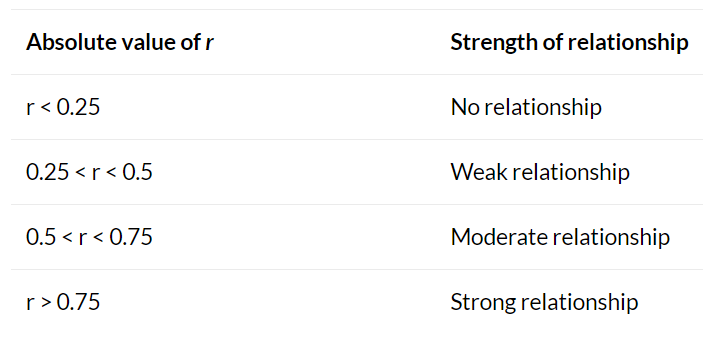



First, we will look at the correlation between each feature and sale price.

Then we will look whether the features are correlated to other features. When the correlation between two features is higher than 0.9, only one of the two features will be used.

In [ ]:
# compute correlations for every feature with the feature sale price
price_correlations = abs(clean_data.corr()['SalePrice'].sort_values())

# determine features with weak, moderate, and strong correlations to sale price
weak_cor = price_correlations[price_correlations < 0.25]
moderate_cor = price_correlations[np.logical_and(price_correlations < 0.75, price_correlations > 0.25)]
strong_cor = price_correlations[price_correlations > 0.70] 

print(f'These features have a weak correlation to selling price\n{weak_cor}\n')
print(f'These features have a moderate correlation to selling price\n{moderate_cor}\n')
print(f'These features have a strong correlation to selling price\n{strong_cor}\n')

# determine relevant numerical features 
relevant_num_features = price_correlations[price_correlations > correlation_treshold].index
print(f"Relevant features are: {', '.join(relevant_num_features)}")

In [ ]:
# creates a heatmap
correlation_features = clean_data[relevant_num_features].corr()
plt.figure(figsize = (10, 10))
sns.heatmap(correlation_features, annot = True)

plt.show()

As seen above, none of the preselected numerical features hold a correlation of 0.9 or higher with eachother. Therefore, all of the features will be selected.

In [ ]:
# create dataframe with numerical data
num_data = clean_data[relevant_num_features]
num_data.head()

## Categorical feature selection

In [ ]:
# create dataframe with categorical data
cat_data = clean_data.select_dtypes(include = 'object')
cat_data.head()

In [ ]:
# determine minimal and max house saleprice of dataset
max_price = clean_data['SalePrice'].max()
min_price = clean_data['SalePrice'].min()

In [ ]:
# plot categorical features in relation to sale price
def barplots(cat_data):
    """
    Plots mainly categorical subfeatures as barplots
    """
    for feature in cat_data:
        sns.barplot(x = feature, y = 'SalePrice', data = clean_data)
        plt.xticks(rotation = 90)
        plt.ylim(min_price, max_price)
        plt.show()

**Determine which categorical features have strongest influence on sale price**

Housing prices for these features should have at least 10% average difference between categories.

For computing the average difference between housing prices of categories per feature, we used some code from: https://docs.python.org/3/library/itertools.html


In [ ]:
import operator
import itertools

def select_cat_features(cat_data, perc_diff):
    """
    Store the most useful categorical features in a list and return that list.
    Useful categroical features are selected by the effect they have on the sale price,
    in terms of mean sale price range within a feature (between its categories) and
    how big that range is compared to the sale price range of the whole dataset.
    The treshold is expressed in percentage of this sale price range.
    """
    
    relevant_cat_features = []

    # set treshold on 10% sale price difference per feature
    treshold = (max_price - min_price) * perc_diff

    for feature in cat_data:
        
        # compute avereages for every feature for each category
        avg_sp = clean_data.groupby(feature).mean().reset_index()

        # we only need the average sale price and convert it to a list
        sp_means = avg_sp['SalePrice'].tolist()

        # compute average difference between housing prices of categories per feature
        diffs = [abs(e[1] - e[0]) for e in itertools.permutations(sp_means, 2)]
        mean_diff = sum(diffs)/len(diffs)
        
        # determine if feature passes the treshold for influenceon housing price
        if mean_diff > treshold:
            relevant_cat_features.append(feature)
            
    print("\ntreshold:", treshold)
            
    return relevant_cat_features

# remove irrelevant features from cat data
rel_cat_features = select_cat_features(cat_data, percentage_treshold)
print('the relevant categorical features are:', rel_cat_features)
cat_data = clean_data[rel_cat_features]

In [ ]:
# get dummies from cat data
if get_dummies == True:
    cat_data = pd.get_dummies(cat_data, drop_first=True)

## Rescaling data

In [ ]:
# temporary remove target value Saleprice
# because these should not be rescaled
target = num_data['SalePrice']
num_data = num_data.drop(['SalePrice'], axis=1)

# store houses unique ID's in seperate series
ID = clean_data['PID']

# transform Sale Price in log Sale Price
target = np.log10(target)

# feature scale numerical data using zscore 
# note that we do not want to normalize our one-hot encoded data as those are already within [0,1] range
# source: "https://stackoverflow.com/a/41713622"
num_data = num_data.apply(zscore)

In [ ]:
# merge categorical and numerical dataframe
num_data = pd.concat([num_data, target, ID], axis = 1)
clean_data = pd.concat([cat_data, num_data], axis = 1)

# check ditribution of data
display(clean_data.describe())

## Splitting data in test and training data

In [ ]:
# extract training and test houses in clean_data with ID
train_ID = train_data['PID'].to_numpy()
test_ID = test_data['PID'].to_numpy()

# split dataframe into test and train data
train_data = clean_data[clean_data['PID'].isin(train_ID)]
test_data = clean_data[clean_data['PID'].isin(test_ID)]

In [ ]:
# drop PID's
clean_data = clean_data.drop('PID', axis=1)
train_data = train_data.drop('PID', axis=1)
test_data = test_data.drop('PID', axis=1)

In [ ]:
# display info clean_data
clean_data.head()

## Exporting data to csv files

In [ ]:
if get_dummies == True:
    # export final cleaned dataframe to csv file  
    clean_data.to_csv('data/preprocess_data.csv', index=False)  
    train_data.to_csv('data/preprocess_train_data.csv', index=False)
    test_data.to_csv('data/preprocess_test_data.csv', index=False)
    
else: 
    # export final cleaned dataframe to csv file  
    clean_data.to_csv('data/preprocess_nodummies_data.csv', index=False)  